The aim in this notebook is to predict the total energy consumption in Germany using prediction time scales between 15 minutes and 24 hours.

First I import the needed python modules. 

In [2]:
import pandas as pd
import numpy as np
import scipy as sp



import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

from datetime import date, time, datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pickle

#add fullr and co 
import statsmodels.tsa.stattools as smtime

#We mainly use xgboost
from xgboost import XGBRegressor
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#trials
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sklearn.metrics as met
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
#needs newest statsmodel 0.14.0 
from statsmodels.tsa.seasonal import MSTL
from functions import *

Now using different method to find best xgboost version

The data is obtained from https://www.smard.de/home/downloadcenter/download-marktdaten/?downloadAttributes=%7B%22selectedCategory%22:2,%22selectedSubCategory%22:false,%22selectedRegion%22:false,%22selectedFileType%22:false%7D
 using the category 'Stromverbrauch' then the subcategory 'realisierter Stromverbrauch', then 'Deutschland', then the subcategory time intervall 'viertelstunde'.
                   
            
That request gets the power consumption of Germany in the best possible resolution of 15 minutes. To get all availble data (nearly 8 years) it is needed to download in six pieces. 

In [3]:
#path to the data
path='/home/tobias/ml-testing/energy/'
#getting the data which is in four pieces
real_power1=pd.read_csv(path+"Realisierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
real_power4=pd.read_csv(path+"Realisierter_Stromverbrauch_201501010000_201611302359.csv",delimiter=';')
real_power3=pd.read_csv(path+"Realisierter_Stromverbrauch_201612010000_201811302359.csv",delimiter=';')
real_power2=pd.read_csv(path+"Realisierter_Stromverbrauch_201812010000_202011302359.csv",delimiter=';')
real_power5=pd.read_csv(path+"Realisierter_Stromverbrauch_202211150000_202401022359_Viertelstunde.csv",delimiter=';')
real_power6=pd.read_csv(path+"Realisierter_Stromverbrauch_202401030000_202403112359_Viertelstunde.csv",delimiter=';')

Processing them. 

In [4]:
print(real_power5.columns)

Index(['Datum', 'Anfang', 'Ende',
       'Gesamt (Netzlast) [MWh] Originalauflösungen',
       'Residuallast [MWh] Originalauflösungen',
       'Pumpspeicher [MWh] Originalauflösungen'],
      dtype='object')


In [5]:
processed1=prepare_input(real_power1,old=True,str_convert=False)
processed2=prepare_input(real_power2,old=True,str_convert=False)
processed3=prepare_input(real_power3,old=True,str_convert=False)
processed4=prepare_input(real_power4,old=True,str_convert=False)
processed5=prepare_input(real_power5,old=False,str_convert=True)
processed6=prepare_input(real_power6,old=False,str_convert=True)

/home/tobias/ml-testing/energy/energy-timeseries/functions.py:558: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:561: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:558: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/

Combine them and plot for checking. 

dimensions of the data are (355488, 5)


Text(0, 0.5, 'total power [GW]')

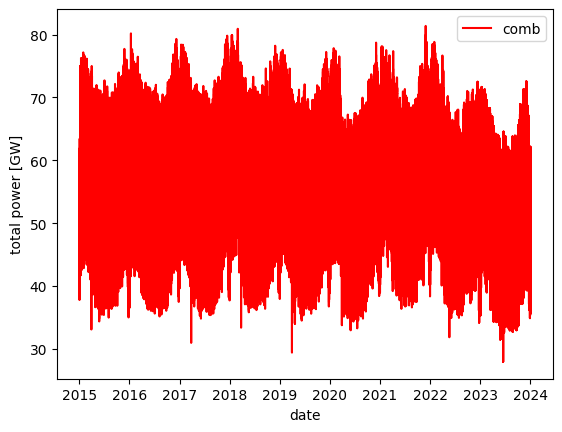

In [6]:
#date_time is set to index
processed1=processed1.set_index('date_time')
processed2=processed2.set_index('date_time')
processed3=processed3.set_index('date_time')
processed4=processed4.set_index('date_time')
processed5=processed5.set_index('date_time')
processed6=processed6.set_index('date_time')

#combining with concat
comb_real_power=pd.concat([processed4,processed3,processed2,processed1,processed5,processed5])
#reset index for easier handling
comb_real_power=comb_real_power.reset_index()
print(f"dimensions of the data are {comb_real_power.shape}")
plt.plot(comb_real_power['date_time'],comb_real_power['total_power']*4,'-',ms=1,color='red',label='comb') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("total power [GW]")

Including new worked. 

In [7]:
#freeing space 
real_power1=0
real_power2=0
real_power3=0
real_power4=0
real_power5=0
real_power6=0
processed1=0
processed2=0
processed3=0
processed4=0
processed5=0
processed6=0

No official predictions for now. 

In [8]:
#pred_power1=pd.read_csv(path+"Prognostizierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
#pred_power4=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201501010000_201611302359_Viertelstunde.csv",delimiter=';')
#pred_power3=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201612010000_201811302359_Viertelstunde.csv",delimiter=';')
#pred_power2=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201812010000_202011302359_Viertelstunde.csv",delimiter=';')
#pred_power5=pd.read_csv(path+"Prognostizierter_Stromverbrauch_202211150000_202401022359_Viertelstunde.csv",delimiter=';')

No gap prediction for now. 

In [9]:
#first now then to predict, here the 96 will be varies to get for many periods 
ser=series_to_supervised(comb_real_power.total_power,1,96)
print(ser.shape,ser[0:10,0:10])

(355391, 2) [[11.21  11.306]
 [11.119 11.019]
 [11.145 10.877]
 [11.127 10.818]
 [11.01  10.687]
 [10.923 10.616]
 [10.817 10.55 ]
 [10.705 10.5  ]
 [10.65  10.451]
 [10.547 10.405]]


Make to data frame

In [10]:
df_ser=pd.DataFrame(ser,columns=["now","to_predict"])
df_ser.loc[:,'frac_day']=comb_real_power.loc[0:df_ser.shape[0],'frac_day']
df_ser.loc[:,'frac_week']=comb_real_power.loc[0:df_ser.shape[0],'frac_week']
df_ser.loc[:,'frac_year']=comb_real_power.loc[0:df_ser.shape[0],'frac_year']

In [11]:
print(df_ser.columns)
frac1=int(df_ser.shape[0]*0.8)
print(frac1)
ser_train=df_ser.iloc[:frac1,:]
ser_test=df_ser.iloc[frac1:,:]
x_train=ser_train.loc[:,['now','frac_day', 'frac_week']]
y_train=ser_train.loc[:,'to_predict']
x_test=ser_test.loc[:,['now','frac_day', 'frac_week']]
y_test=ser_test.loc[:,'to_predict']

Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year'], dtype='object')
284312


In [12]:
model = XGBRegressor()
eval_set = [(x_test, y_test)]

In [13]:
model.fit(x_train, y_train, early_stopping_rounds=3, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:8.84783
[1]	validation_0-rmse:6.14726


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:4.27156
[3]	validation_0-rmse:2.97814
[4]	validation_0-rmse:2.09120
[5]	validation_0-rmse:1.49641
[6]	validation_0-rmse:1.10197
[7]	validation_0-rmse:0.86688
[8]	validation_0-rmse:0.75059
[9]	validation_0-rmse:0.69455
[10]	validation_0-rmse:0.67583
[11]	validation_0-rmse:0.67314
[12]	validation_0-rmse:0.67548
[13]	validation_0-rmse:0.67800
[14]	validation_0-rmse:0.68224


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [14]:
y_pred = model.predict(x_test)

In [15]:
#uses best automatically, maybe always, but jsut fatsre wouldf be enough of adventage 
print(((y_test-y_pred)/np.mean(y_pred)).describe())

count    71079.000000
mean        -0.002477
std          0.051516
min         -0.390916
25%         -0.025945
50%          0.000907
75%          0.025662
max          0.245938
Name: to_predict, dtype: float64


5.15% standard deviation, same as before (slightky different test sample), but should be faster. 

In [16]:
print(model.evals_result())
results = model.evals_result()
s=np.argmin(results['validation_0']['rmse'])
print(results['validation_0']['rmse'][s])

{'validation_0': OrderedDict([('rmse', [8.847827382548546, 6.147258290231909, 4.2715608731869175, 2.978144023720723, 2.09119826494975, 1.4964136543156505, 1.1019666035645876, 0.8668757142475173, 0.7505882823608969, 0.6945474752296621, 0.6758343725292242, 0.6731356594667031, 0.675480350334407, 0.6779966506491001, 0.6822386853970432])])}
0.6731356594667031


In [17]:
x_train2=ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']]
y_train2=ser_train.loc[:,'to_predict']
x_test2=ser_test.loc[:,['now','frac_day', 'frac_week', 'frac_year']]
y_test2=ser_test.loc[:,'to_predict']
model2 = XGBRegressor()
eval_set2 = [(x_test2, y_test2)]

In [18]:
model2.fit(x_train2, y_train2, early_stopping_rounds=3, eval_metric="rmse", eval_set=eval_set2, verbose=True)

[0]	validation_0-rmse:8.84521


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:6.13913
[2]	validation_0-rmse:4.25771
[3]	validation_0-rmse:2.94930
[4]	validation_0-rmse:2.02929
[5]	validation_0-rmse:1.43781
[6]	validation_0-rmse:1.03421
[7]	validation_0-rmse:0.79341
[8]	validation_0-rmse:0.67062
[9]	validation_0-rmse:0.61581
[10]	validation_0-rmse:0.60195
[11]	validation_0-rmse:0.59536
[12]	validation_0-rmse:0.60120
[13]	validation_0-rmse:0.60564
[14]	validation_0-rmse:0.60885


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [19]:

y_pred2 = model2.predict(x_test2)
print(((y_test2-y_pred2)/np.mean(y_pred2)).describe())

count    71079.000000
mean        -0.008739
std          0.044480
min         -0.405448
25%         -0.030084
50%         -0.005224
75%          0.016811
max          0.224894
Name: to_predict, dtype: float64


In [20]:
#feature_train, target_train, feature_test, target_train, max depth of xgb, needs always be set *6 is equal to default), optional regularization alpha (larger less overfitting)
#now best n_est, is given back, that not more are run
def do_xgb_nest(feature_train, target_train, feature_test, target_test,max_depth,reg=0,silent=False,rounds=3):
    start_time=datetime.now()
    #no regularization option
    if reg==0:
        model = XGBRegressor(max_depth=max_depth)
    else:
        model = XGBRegressor(max_depth=max_depth,reg_alpha=reg)   
    eval_set = [(feature_test, target_test)]
    model.fit(feature_train, target_train, early_stopping_rounds=rounds, eval_metric="rmse", eval_set=eval_set, verbose=silent)
    results = model.evals_result()
    s=np.argmin(results['validation_0']['rmse'])
    predli1texl27=model.predict(feature_test)
    predli1trxl27=model.predict(feature_train)
    test_scatter=np.std(predli1texl27-target_test)
    train_scatter=np.std(predli1trxl27-target_train)
    test_m=np.mean(predli1texl27-target_test)
    train_m=np.mean(predli1trxl27-target_train)
    test_rsme=np.sqrt((test_m**2+test_scatter**2))
    train_rsme=np.sqrt((train_m**2+train_scatter**2))   
    if silent==False:
        print(f"best n_estimator is {s+1}")
        print(f"rsme of test {round(test_rsme,4)} points")
        print(f"rsme of train {round(train_rsme,4)} points")
    #copy result to array which can be used by other function
    ar=np.zeros((5))
    ar[0]=reg
    ar[1]=max_depth
    ar[2]=train_rsme
    ar[3]=test_rsme
    ar[4]=s+1   
    stop_time=datetime.now()
    if silent==False:
        print(f"xgb took {(stop_time-start_time)} seconds")
    return ar

In [21]:
test_res=do_xgb_nest(x_train,y_train,x_test,y_test,max_depth=4,rounds=10)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


best n_estimator is 45
rsme of test 0.6796 points
rsme of train 0.6242 points
xgb took 0:00:02.288270 seconds


In [22]:
test_res2=do_xgb(x_train,y_train,x_test,y_test,max_depth=4)

standard deviation of test 2.2568 points
standard deviation of train 2.4945  points
standard deviation of prediction-test 0.6763 points
standard deviation of prediction-train 0.6073 points
xgb took 0:00:03.379457 seconds


Yes is faster now, when round number is small. Also rsme used which helps to reduce the bias. 

In [29]:
def loop_reg_nest(feature_train, target_train, feature_test, target_test,max_depth=6,reg_start=0.01,reg_increase=1.414,reg_steps=20,save=False,file_name=None,regression=True,silent=False,rounds=3,limit=1.05):
    #that takes now some time
    resb=np.zeros((5,reg_steps))
    for i in range(reg_steps):
        if silent==False:
            print(f"doing case {i}")
        regularization=reg_start*reg_increase**i
        #regression
        if regression==True:
            print(rounds)
            ar=do_xgb_nest(x_train,y_train,x_test,y_test,max_depth=max_depth,rounds=rounds,reg=regularization,silent=silent)  
                
        #classification not yet implemented
        else:
            ar=do_xgb_class(feature_train, target_train, feature_test, target_test,max_depth=max_depth,reg=regularization,silent=silent)
        resb[:,i]=ar           
        #early stopping
        if ar[2]>ar[3]*limit:
             return resb[:,:i]
    #saved now only at the end seems stable enough now
    if save==True:
        np.savetxt(file_name, resb) 
    else:
        return resb

In [30]:
test_loop=loop_reg_nest(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_train.to_predict,ser_test.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_test.to_predict,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=40,save=False,regression=True,silent=False,rounds=25,limit=1.02)

doing case 0
25


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


best n_estimator is 45
rsme of test 0.6796 points
rsme of train 0.6242 points
xgb took 0:00:02.803981 seconds
doing case 1
25
best n_estimator is 45
rsme of test 0.6796 points
rsme of train 0.6242 points
xgb took 0:00:02.667033 seconds
doing case 2
25
best n_estimator is 45
rsme of test 0.6796 points
rsme of train 0.6242 points
xgb took 0:00:02.285103 seconds
doing case 3
25
best n_estimator is 45
rsme of test 0.6796 points
rsme of train 0.6242 points
xgb took 0:00:02.403178 seconds
doing case 4
25
best n_estimator is 41
rsme of test 0.6839 points
rsme of train 0.6277 points
xgb took 0:00:01.934277 seconds
doing case 5
25
best n_estimator is 41
rsme of test 0.6839 points
rsme of train 0.6277 points
xgb took 0:00:01.927877 seconds
doing case 6
25
best n_estimator is 44
rsme of test 0.6812 points
rsme of train 0.6261 points
xgb took 0:00:02.639765 seconds
doing case 7
25
best n_estimator is 39
rsme of test 0.6904 points
rsme of train 0.6295 points
xgb took 0:00:02.348185 seconds
doing ca

Text(0.5, 1.0, '4 features')

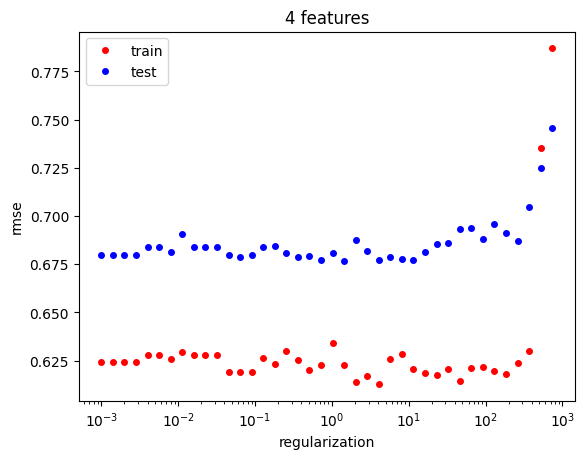

In [28]:

plt.plot(test_loop[0],test_loop[2],'o',ms=4,color='red',label="train")  
plt.plot(test_loop[0],test_loop[3],'o',ms=4,color='blue',label="test")  
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("regularization")
plt.ylabel("rmse")
plt.xscale("log")
plt.title("4 features")

More scatter than before, 10 and 12, 15 rounds not enough. I am not convinvced that this method really makes it better. Now seems to work with 25, somewhat doubtful, that this still really better, speed wise. 

Text(0.5, 1.0, '4 features')

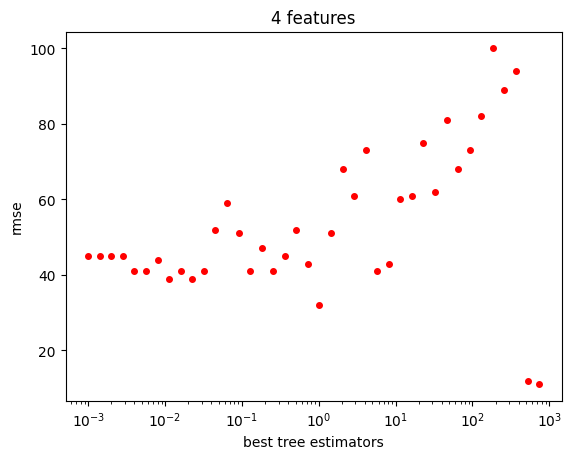

In [26]:

plt.plot(test_loop[0],test_loop[4],'o',ms=4,color='red',label="train")  
#plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("best tree estimators")
plt.ylabel("rmse")
plt.xscale("log")
plt.title("4 features")

In [27]:
plt.bar(ser_train.loc[:,['now','frac_day', 'frac_week']].columns, xmodel1.feature_importances_)
plt.show()

NameError: name 'xmodel1' is not defined

Fraction of day is not important, probably its prediction properrties are similar as current state. 

In [ ]:
plt.bar(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']].columns, xmodel2.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

When year is added actually year does not matter much buts makes frac week less important. 

Netx options, try some grid. Try more precursor data, likely average of several, since when a day is in between exatcly before does not matter so much. 

In [ ]:
from ib_functions_ml import *

In [ ]:
loop_reg(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_train.to_predict,ser_test.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_test.to_predict,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=40,file_name='xgb_4_v1.txt',regression=True,silent=False)

In [ ]:
x1=np.loadtxt('xgb_4_v1.txt')


plt.plot(x1[0],x1[2]/np.mean(ser_test.to_predict),'o',ms=4,color='red',label="train")  
plt.plot(x1[0],x1[3]/np.mean(ser_test.to_predict),'o',ms=4,color='blue',label="test")  
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("regularization")
plt.ylabel("standard deviation [%]")
plt.xscale("log")
plt.title("4 features")

Some imporve,ent but not yet clear that it is the optimum. Also noisy, thus should fit it with parabola to use the best one.   Needs to divide by std test to get usual. A little better then about 4.05%. 

Function to find minimum. 

In [ ]:
#quadrtyic logarithm
def log_quat(x,a,b,c):
    return a+b*np.log10(x)+c*np.log10(x)**2

In [90]:
def dev_quat(a,b,c):
    return -b/(2*c)
    

In [91]:
def find_best(dat,delta=3):
    min_p=np.argmin(dat[3])
    est=np.zeros((3))
    print(dat[0,min_p])
    print(dat[0:4,min_p-delta:min_p+delta])
    if min_p-delta>=0:
        val,cov=sp.optimize.curve_fit(log_quat,dat[0,min_p-delta:min_p+delta],dat[3,min_p-delta:min_p+delta],p0=est)
    else:
        val,cov=sp.optimize.curve_fit(log_quat,dat[0,0:min_p+delta],dat[3,0:min_p+delta],p0=est)
    print(val)
    min_p1=10**dev_quat(val[0],val[1],val[2])
    return min_p1
    

In [49]:
a=log_quat(10,0,1,2)
print(a)
best_reg=find_best(x1,delta=4)

3.0
4.0811807269213
[[ 1.02091172  1.44356917  2.04120681  2.88626643  4.08118073  5.77078955
   8.15989642 11.53809354]
 [ 4.          4.          4.          4.          4.          4.
   4.          4.        ]
 [ 0.46721099  0.47649101  0.47238429  0.47309713  0.47664354  0.47848415
   0.47963171  0.47402545]
 [ 0.56785682  0.56704723  0.57060385  0.56394261  0.56056985  0.5646941
   0.56097686  0.56867295]]
[ 0.56992589 -0.01918939  0.01453615]


In [50]:
xmodel3=XGBRegressor(alpha=best_reg).fit(df_ser.loc[:,['now','frac_day', 'frac_week', 'frac_year']],df_ser.loc[:,'to_predict'])
xmodel3.save_model("xgb_model_096.json")


In [39]:
xmodel4=XGBRegressor()
xmodel4.load_model("xgb_model_096.json")

Basic works, now making all to a function that it can be produced for a number of time deltas. 
First for single time delta. 

Should give out standard deviation of test at some point also. 

In [92]:
#parameters data frame, gap to wanted prediction
def find_fit_best_reg(df,gap,now_points=1,test_frac=0.8,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=4,delta=4,filename=None,save=True):
    ser=series_to_supervised(df.total_power,now_points,gap)
    df_ser=pd.DataFrame(ser,columns=["now","to_predict"])
    df_ser.loc[:,'frac_day']=df.loc[0:df_ser.shape[0],'frac_day']
    df_ser.loc[:,'frac_week']=df.loc[0:df_ser.shape[0],'frac_week']
    df_ser.loc[:,'frac_year']=df.loc[0:df_ser.shape[0],'frac_year']
    print(df_ser.shape)
    print(df_ser.columns)
    frac1=int(df_ser.shape[0]*0.8)
    print(frac1)
    ser_train=df_ser.iloc[:frac1,:]
    ser_test=df_ser.iloc[frac1:,:]
    print(reg_steps)
    stat_reg=loop_reg(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_train.to_predict,ser_test.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_test.to_predict,max_depth=max_depth,reg_start=reg_start,reg_increase=reg_increase,reg_steps=reg_steps,Save=False,regression=True,silent=False)
    print(stat_reg)
    best_reg=find_best(stat_reg,delta=delta)
    xmodel=XGBRegressor(alpha=best_reg).fit(df_ser.loc[:,['now','frac_day', 'frac_week', 'frac_year']],df_ser.loc[:,'to_predict'])
    if save==True:
        xmodel.save_model(filename)
    else:
        return xmodel

In [44]:
find_fit_best_reg(comb_real_power,0,reg_steps=40,filename="xgb_model_000.json")

(315743, 5)
Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year'], dtype='object')
252594
40
doing case 0
xgb took 4.359 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.0923 points
standard deviation of prediction-train 0.0783 points
doing case 1
xgb took 4.0691 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.0917 points
standard deviation of prediction-train 0.0778 points
doing case 2
xgb took 3.8037 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.093 points
standard deviation of prediction-train 0.0776 points
doing case 3
xgb took 3.887 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.094 points
standard deviation of prediction-train 0.0797 po

xgb took 4.5944 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.1144 points
standard deviation of prediction-train 0.111 points
doing case 37
xgb took 3.8193 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.1235 points
standard deviation of prediction-train 0.1216 points
doing case 38
xgb took 3.5056 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.1294 points
standard deviation of prediction-train 0.1283 points
doing case 39
xgb took 3.4645 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.1388 points
standard deviation of prediction-train 0.14 points
[[1.00000000e-03 1.41400000e-03 1.99939600e-03 2.82714594e-03
  3.99758436e-03 5.65258429e-03 7.99275419e-03 

In [ ]:
Seems to work. 

Make function to many of them. 

In [93]:
def fit_many_gaps(df,gap_start=1,gap_steps=2,now_points=1,test_frac=0.8,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=4,delta=4,filename=None,save=True):
    for i in range(gap_steps):
        gap=gap_start+i
        print(gap)
        if gap<10:
            filename="xgb_model_00"+str(gap)+".json"
        elif gap<100:
            filename="xgb_model_0"+str(gap)+".json"
        elif gap<1000:
            filename="xgb_model_"+str(gap)+".json"            
        find_fit_best_reg(df,gap,now_points=now_points,test_frac=test_frac,max_depth=max_depth,reg_start=reg_start,reg_increase=reg_increase,reg_steps=reg_steps,delta=delta,filename=filename,save=True)

In [120]:
#9:37 start finish before 9:43 for 2
# for 10 start at 9:45 finish 10:17
#now running enough for 2 day prediction 
fit_many_gaps(comb_real_power,reg_steps=40,reg_start=0.0012,gap_start=44,gap_steps=1)

44
(315699, 5)
Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year'], dtype='object')
252559
40
doing case 0
xgb took 3.3086 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.6144 points
standard deviation of prediction-train 0.4729 points
doing case 1
xgb took 2.8862 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.6144 points
standard deviation of prediction-train 0.4729 points
doing case 2
xgb took 3.0695 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.6144 points
standard deviation of prediction-train 0.4729 points
doing case 3
xgb took 2.9256 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.6144 points
standard deviation of prediction-train 0.4729

xgb took 4.4128 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.6393 points
standard deviation of prediction-train 0.5212 points
doing case 37
xgb took 4.6599 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.6477 points
standard deviation of prediction-train 0.5309 points
doing case 38
xgb took 4.585 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.648 points
standard deviation of prediction-train 0.5432 points
doing case 39
xgb took 4.5557 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.6625 points
standard deviation of prediction-train 0.5566 points
[[1.20000000e-03 1.69680000e-03 2.39927520e-03 3.39257513e-03
  4.79710124e-03 6.78310115e-03 9.59130503e-03 1.3

Next make function which can predict flux from the now data point into the future. 

In [121]:
#parameters, most recent features, list of model,delta ts, standard is just every 0.25 h from models
def predict_from_now(data,models,deltas=None):
    print(data)
    if deltas==None:
        deltas=np.zeros((len(models)))
        for i in range(len(models)):
            deltas[i]=0.25+i/4
    res=np.zeros((3,len(models)))  
    res[0,:]=deltas
    for i in range(len(models)):
        print(i)
        xmodel=XGBRegressor()
        xmodel.load_model(models[i])
        #predict needs more than 1 data point to work 
        res[1,i]=xmodel.predict(data)[-1]
    #need better column names at some points in a data frame     
    return res     

In [22]:
print(comb_real_power.loc[comb_real_power.shape[0]-1,['total_power','frac_day', 'frac_week', 'frac_year']])
myPath='/home/tobias/ml-testing/energy/energy-timeseries'
models=[f for f in os.listdir(myPath) 
    if (f.startswith('xgb_model_')) and  (f.endswith('json') )] 
models.sort()
print(models)

KeyError: "['frac_day', 'frac_week', 'frac_year'] not in index"

In [123]:
prediction=predict_from_now(comb_real_power.loc[comb_real_power.shape[0]-3:comb_real_power.shape[0],['total_power','frac_day', 'frac_week', 'frac_year']],models[:])

        total_power  frac_day  frac_week  frac_year
315741     12.09550  0.968750   0.852679   0.004706
315742     11.83150  0.979167   0.854167   0.004734
315743     11.72175  0.989583   0.855655   0.004763
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


In [124]:
prediction2=predict_from_now(comb_real_power.loc[comb_real_power.shape[0]-3:comb_real_power.shape[0]-2,['total_power','frac_day', 'frac_week', 'frac_year']],models[:])

        total_power  frac_day  frac_week  frac_year
315741      12.0955  0.968750   0.852679   0.004706
315742      11.8315  0.979167   0.854167   0.004734
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


Seems to work and relatively fast, likely fats enough for doing it every 15 mimnutes.
Not crazy fast but good enough for now. 

[[11.         16.05557632]
 [11.25       16.3004055 ]
 [11.5        16.71058273]
 [11.75       16.44300652]
 [12.         16.55988121]
 [12.25       16.55244637]
 [12.5        16.56935883]]


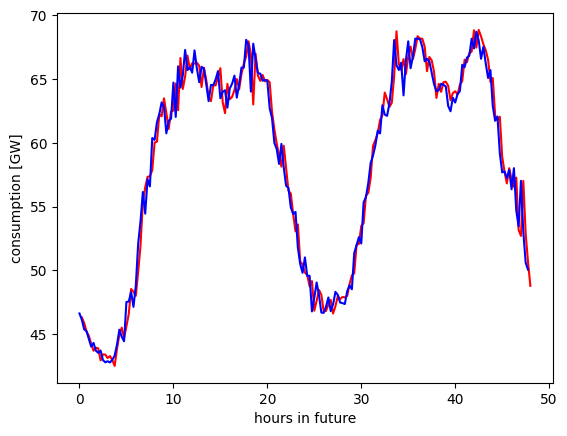

In [125]:
plt.plot(prediction[0],prediction[1]*4,color='red')
plt.plot(prediction2[0]-0.25,prediction2[1]*4,color='blue')
plt.xlabel("hours in future")
plt.ylabel("consumption [GW]")    
print(prediction[0:2,43:50].T)

LOoks plausible mostly, also not with much wiggles, but one is rather bad close to 10 hours. 
That seem to be general bad, rerun withg 20% offset regularization start. That solved the problem, others are more like noise without a clear wrong solution. 
Those wiggles are a kind of noise not really expected, whether bad depends on whether it should look better as it is or not. 

Still looks good that it can be implemented. 

## Further improvement ideas
- Need track metrics 
- Start year on 1 march because of 29 February.
- Add something special datawise for days infleunces by eastern, could be in main models or in special model only used sometimes
- Add more past (possible average) data points
